# 5.3 사전 훈련된 컨브넷 사용하기
- **사전 훈련된 네트워크**(pretrained network) : 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크
- 학습된 특성을 다른 문제에 적용할 수 있다는 점이 장점
- VGG16 : 1400만개 이미지, 1000개 클래스로 이루어진 ImageNet 데이터셋에서 훈련된 대규모 컨브넷으로 2014년 개발
    - 조금 오래되고 다른 모델보다 조금 무거우며 성능이 최고 수준은 아니지만 모델 구조가 이해하기 쉬움

## 5.3.1 특성 추출
- **특성 추출**(feature extraction) : 사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 흥미로운 특성을 뽑아내는 것
- 컨브넷 구조를 합성곱+풀링 층(**합성곱 기반 층**(convolution base)) + 완전 연결 분류기라고 생각
- 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반 층을 선택하여 새로운 데이터를 통과시키고 그 출력으로 새로운 분류기를 훈련
    - 완전 연결 분류기는 재사용하지 않음
    - 합성곱 층에 의해 학습된 표현이 더 일반적이기 때문
    - 완전 연결 분류기는 모델이 훈련된 클래스 집합에 특화되어 있어 일반적이지 못함
- 특정 합성곱 층에서 추출한 표현의 일반성 수준은 모델에 있는 층의 깊이에 따라 다름
    - 하위 층 : 지역적이고 매우 일반적인 특성 맵 (에지, 색깔, 질감 등)
    - 상위 층 : 추상적인 개념 (강아지 눈, 고양이 귀 등)
    - 그러므로 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 하위 층 몇 개만 특성 추출에 사용하는 것이 좋음

### VGG16 합성곱 기반 층 만들기
- `tensorflow.keras.applications` 모듈에서 사용 가능한 이미지 분류 모델
    - Xception
    - Inception V3
    - ResNet50
    - VGG16
    - VGG19
    - MobileNet 등
- `VGG16` 함수의 매개 변수
    - `weights` : 모델을 초기화할 가중치 체크포인트(checkpoint) 지정
    - `include_top` : 네트워크의 최상위 완전 연결 분류기를 포함할지 안 할지 (클래스 1000개)
    - `input_shape` : 네트워크에 주입할 이미지 텐서의 크기
        - 값을 지정하지 않으면 어떤 크기의 입력도 처리할 수 있음
        - `include_top`이 `True`이면 원본 모델과 동일한 `(224, 224, 3)`이 되어야 함

In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

1. 새로운 데이터셋을 합성곱 기반 층에 넣은 출력을 넘파이 배열로 저장한 후 독립된 완전 연결 분류기에 입력으로 사용
    - 합성곱 기반 층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 듬
    - 그러나 데이터 증식을 사용할 수 없음
2. 준비한 모델 위에 `Dense` 층을 쌓아 확장
    - 비용이 많이 듬

### 데이터 증식을 사용하지 않는 빠른 특성 추출

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '../datasets/cats_and_dogs_small/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        
        # 모든 이미지를 한 번씩 처리하고 나면 중지
        if i * batch_size >= sample_count:
            break
    
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features.shape

(2000, 4, 4, 512)

In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### 완전 연결 분류기를 정의하고 훈련하기
- 2개의 `Dense` 층만 처리하면 되기 때문에 훈련이 매우 빠름

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(learning_rate=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.5732 - acc: 0.6805 - val_loss: 0.4346 - val_acc: 0.8350
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4223 - acc: 0.8065 - val_loss: 0.3604 - val_acc: 0.8540
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3593 - acc: 0.8470 - val_loss: 0.3266 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3192 - acc: 0.8675 - val_loss: 0.3052 - val_acc: 0.8750
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2869 - acc: 0.8810 - val_loss: 0.2853 - val_acc: 0.8940
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2630 - acc: 0.8960 - val_loss: 0.2739 - val_acc: 0.8960
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2532 - acc: 0.8990 - val_loss: 0.2689 - val_acc: 0.8920
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

### 결과 그래프 그리기
- 약 90%의 검증 정확도에 도달
- 드롭아웃을 사용했으나 이미지 증식을 사용하지 않았기 때문에 빠르게 과대적합 시작

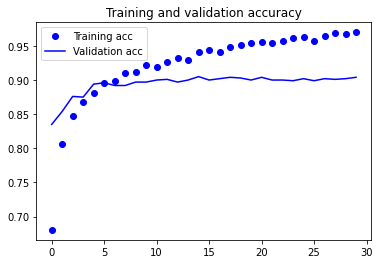

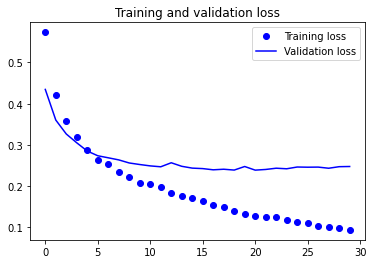

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 데이터 증식을 사용한 특성 추출
- 느리고 비용이 많이 들지만 데이터 증식 기법을 사용하여 과대적합을 막을 수 있음

In [9]:
from tensorflow.keras.layers import Flatten

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### 동결
- 하나 이상의 층을 **동결**(freezing)한다는 것은 훈련하는 동안 가중치가 업데이트 되지 않도록 막는다는 뜻
- 사전에 학습된 표현을 훼손하게 됨
- 동결 후 추가된 2개의 층마다 2개의 가중치(행렬, 편향 벡터) 총 4개의 텐서만 훈련 됨

In [11]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [12]:
conv_base.trainable = False

print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


### 동결된 합성곱 기반 층과 함께 모델을 엔드-투-엔드로 훈련하기

In [14]:
%%time

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 12s - loss: 0.5498 - accuracy: 0.7320 - val_loss: 0.4185 - val_accuracy: 0.8170
Epoch 2/30
100/100 - 12s - loss: 0.4165 - accuracy: 0.8235 - val_loss: 0.3403 - val_accuracy: 0.8620
Epoch 3/30
100/100 - 12s - loss: 0.3571 - accuracy: 0.8580 - val_loss: 0.3047 - val_accuracy: 0.8800
Epoch 4/30
100/100 - 11s - loss: 0.3276 - accuracy: 0.8595 - val_loss: 0.2964 - val_accuracy: 0.8780
Epoch 5/30
100/100 - 12s - loss: 0.3139 - accuracy: 0.8645 - val_loss: 0.2782 - val_accuracy: 0.8860
Epoch 6/30
100/100 - 12s - loss: 0.2953 - accuracy: 0.8780 - val_loss: 0.2619 - val_accuracy: 0.8890
Epoch 7/30
100/100 - 12s - loss: 0.2758 - accuracy: 0.8885 - val_loss: 0.2574 - val_accuracy: 0.8920
Epoch 8/30
100/100 - 12s - loss: 0.2635 - accuracy: 0.8925 - val_loss: 0.2568 - val_accuracy: 0.8920
Epoch 9/30
100/100 - 12s - loss: 0.2529 - accuracy: 0.9020 - val_loss: 0.2482 - val_accuracy: 0.8970
Epoch 1

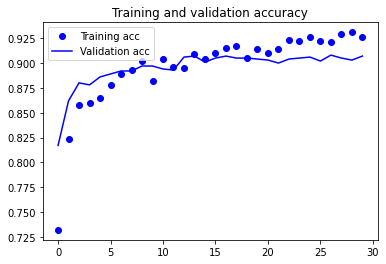

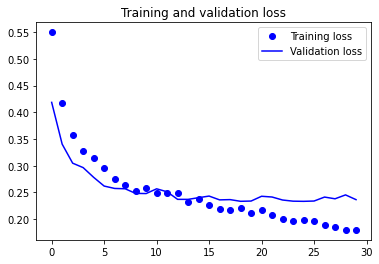

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 5.3.2 미세 조정
- **미세 조정**(fine-tuning) : 동결 층 일부를 해제하고 훈련하는 것
- 맨 위에 있는 분류기(완전 연결 분류기)가 훈련된 후에 합성곱 기반의 상위 층을 미세 조정
    - 훈련되지 않은 상태에서 미세 조정을 하면 사전에 학습된 표현들이 망가지게 됨
- 미세 조정 단계
    1. 사전 훈련 네트워크 위에 새로운 네트워크 추가
    2. 기반 네트워크 동결
    3. 새로 추가한 네트워크 훈련
    4. 기반 네트워크에서 일부 층의 동결을 해제
    5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련
- VGG16 예제에서는 마지막 3개(`block5`) 합성곱 층 미세 조정
- 더 많은 층을 미세조정하지 않는 이유
    - 상위 층은 특화된 특성을 인코딩하므로 새로운 문제에 재활용하기 위해 상위 층을 미세 조정하는 것이 유리
        - 하위 층으로 갈수록 미세 조정에 대한 효과가 감소
    - 훈련해야 할 파라미터가 많을수록 과대적합의 위험이 커짐
        - 1,500만 개의 파라미터를 작은 데이터셋으로 훈련하려고 하면 매우 위험함

### 특정 층까지 모든 층 동결하기

In [16]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

### 모델 미세 조정하기
- 학습률을 낮춰 미세 조정하는 3개의 층에서 학습된 표현을 조금씩 수정

In [17]:
%%time

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 13s 115ms/step - loss: 0.2026 - accuracy: 0.9195 - val_loss: 0.2698 - val_accuracy: 0.8940
Epoch 2/100
100/100 [==============================] - 11s 113ms/step - loss: 0.1637 - accuracy: 0.9400 - val_loss: 0.2213 - val_accuracy: 0.9080
Epoch 3/100
100/100 [==============================] - 11s 114ms/step - loss: 0.1367 - accuracy: 0.9490 - val_loss: 0.2281 - val_accuracy: 0.9140
Epoch 4/100
100/100 [==============================] - 11s 114ms/step - loss: 0.1301 - accuracy: 0.9460 - val_loss: 0.2198 - val_accuracy: 0.9180
Epoch 5/100
100/100 [==============================] - 12s 116ms/step - loss: 0.0955 - accuracy: 0.9670 - val_loss: 0.2415 - val_accuracy: 0.9110
Epoch 6/100
100/100 [==============================] - 12s 120ms/step - loss: 0.1002 - accuracy: 0.9600 - val_loss: 0.2608 - val_accuracy: 0.9060
Epoch 7/100
100/100 [==============================] - 12s 122ms/step - loss: 0.0923 - accuracy: 0.9630 - val_loss: 0.2327 -

100/100 [==============================] - 12s 120ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.3266 - val_accuracy: 0.9310
Epoch 57/100
100/100 [==============================] - 12s 121ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.3334 - val_accuracy: 0.9350
Epoch 58/100
100/100 [==============================] - 12s 122ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.3448 - val_accuracy: 0.9350
Epoch 59/100
100/100 [==============================] - 12s 119ms/step - loss: 0.0093 - accuracy: 0.9980 - val_loss: 0.3235 - val_accuracy: 0.9340
Epoch 60/100
100/100 [==============================] - 12s 121ms/step - loss: 0.0035 - accuracy: 0.9980 - val_loss: 0.3303 - val_accuracy: 0.9360
Epoch 61/100
100/100 [==============================] - 12s 120ms/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.3400 - val_accuracy: 0.9360
Epoch 62/100
100/100 [==============================] - 12s 122ms/step - loss: 0.0026 - accuracy: 0.9985 - val_loss: 0.3659 - val_a

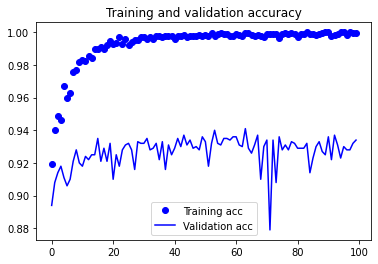

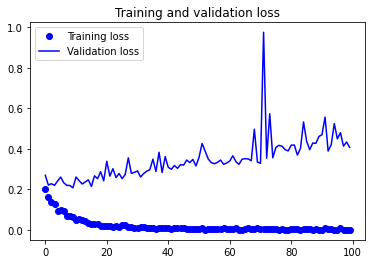

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 부드러운 그래프 그리기
- **지수 이동 평균**(exponential moving averages)으로 부드럽게 표현

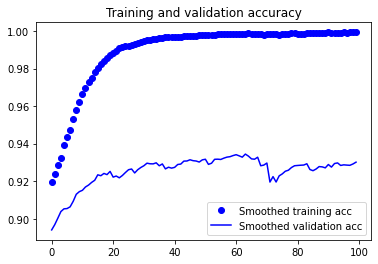

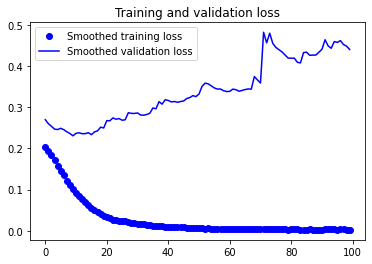

In [19]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 정확도가 미세 조정 전 90%에서 미세 조정 후 94%로 상승
- 손실이 감소하지 않았는데 정확도는 안정된 이유 : 정확도에 영향을 미치는 것은 손실 값의 분포이지 평균이 아니기 때문
- 모델이 더 향상되더라도 평균 손실에 반영되지 않을 수 있음

### 테스트 데이터로 평가

In [20]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

tset_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc :', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 3s 60ms/step - loss: 0.4685 - accuracy: 0.9360
test acc : 0.9359999895095825
